In [1]:
%load_ext autoreload
%autoreload 2

import pydrake
import torch
import pyro
from pyro import poutine
import time
import matplotlib.pyplot as plt

import scene_generation.data.dataset_utils as dataset_utils

from scene_generation.models.planar_multi_object_multi_class_2 import MultiObjectMultiClassModel

In [2]:
import numpy as np
DATA_DIR_TRAIN = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes_geometric_train/"
DATA_DIR_TEST = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes_geometric_test/"
#DATA_FILE = "/home/gizatt/projects/scene_generation/data/planar_bin/planar_bin_static_scenes.yaml"
scenes_dataset_yaml = dataset_utils.ScenesDataset(DATA_DIR_TRAIN)
params_by_object_class = {}
for env_i in range(len(scenes_dataset_yaml)):
    env = scenes_dataset_yaml[env_i]
    for obj_i in range(env["n_objects"]):
        obj_yaml = env["obj_%04d" % obj_i]
        class_name = obj_yaml["class"]
        if class_name not in params_by_object_class.keys():
            params_by_object_class[class_name] = []
        params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])

for object_name in params_by_object_class.keys():
    print object_name, ": "
    params = np.stack(params_by_object_class[object_name])
    print params.shape
    print "means: ", np.mean(params, axis=0)
    print "vars: ", np.std(params, axis=0)

2d_box : 
(1510, 5)
means:  [-0.00371443  0.20759757  3.18695539  0.20160889  0.19990408]
vars:  [0.50918407 0.13616483 2.058654   0.05797807 0.05683715]
2d_sphere : 
(1439, 4)
means:  [-0.00600295  0.19761115  3.02346099  0.10034529]
vars:  [0.53100276 0.13741507 2.52335696 0.02831135]


In [3]:
scenes_dataset = dataset_utils.ScenesDatasetVectorized(DATA_DIR_TRAIN, max_num_objects=20)
data = scenes_dataset.get_full_dataset()

scenes_dataset_test = dataset_utils.ScenesDatasetVectorized(DATA_DIR_TEST, max_num_objects=20)
data_test = scenes_dataset_test.get_full_dataset()

print "Train # batches: ", data.batch_size
print "Test # batches: ", data_test.batch_size

Train # batches:  328
Test # batches:  81


In [28]:
# Rig for SVI, running with AutoDelta, which converges fairly reliably but
# confuses the variances
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList
import datetime
from tensorboardX import SummaryWriter

pyro.enable_validation(True)

log_dir = "/home/gizatt/projects/scene_generation/models/runs/pmomc2/" + datetime.datetime.now().strftime(
    "%Y-%m-%d-%H-%m-%s")
writer = SummaryWriter(log_dir)
def write_np_array(writer, name, x, i):
    for yi, y in enumerate(x):
        writer.add_scalar(name + "/%d" % yi, y, i)
        
print "All params: ", pyro.get_param_store().get_all_param_names()
interesting_params = ["keep_going_weights",
                      "new_class_weights",
                      "params_means_0", "params_means_1",
                      "params_vars_0", "params_vars_1"]
    
model = MultiObjectMultiClassModel(scenes_dataset)
pyro.clear_param_store()
pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_untrained.pyro")
guide = model.guide

optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model.model, guide, optim, loss=elbo)
losses = []
losses_test = []
snapshots = {}
for i in range(101):
    # Guesses on important things:
    # Big subsamples appear really important -- I had major loss of
    # convergence when using smaller subsample sizes (like ~50).
    # Also important: prior on the variance must be REALLY low.
    # Otherwise long_box_mean diverges to negative... :(
    # I think there's a fundamental problem with variance estimation
    # under this guide / with this system -- see the single-box-dataset
    # estimates that don't capture the x vs y variance.
    loss = svi.step(data, subsample_size=250)
    losses.append(loss)
    writer.add_scalar('loss', loss, i)
    
    loss_test = svi.evaluate_loss(data_test, subsample_size=25)
    loss_test *= float(data.batch_size) / data_test.batch_size
    losses_test.append(loss_test)
    writer.add_scalar('loss_test', loss_test, i)

    for p in pyro.get_param_store().keys():
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(pyro.param(p).cpu().detach().numpy().copy())
    for p in interesting_params:
        write_np_array(writer, p, snapshots[p][-1], i)
    if (i % 10 == 0):
        print ".",
    if (i % 50 == 0):
        print "\n"
        for p in interesting_params:
            print p, ": ", pyro.param(p).detach().numpy()
print "Done"

All params:  ['keep_going_weights', 'context_updater_module$$$weight_hh_l0', 'new_class_weights', 'context_updater_module$$$bias_hh_l0', 'class_encoder_module_1$$$4.bias', 'params_vars_1', 'params_vars_0', 'context_updater_module$$$weight_ih_l0', 'class_encoder_module_0$$$2.weight', 'class_encoder_module_1$$$4.weight', 'class_encoder_module_0$$$4.weight', 'context_updater_module$$$bias_ih_l0', 'class_encoder_module_0$$$0.weight', 'class_encoder_module_0$$$4.bias', 'class_encoder_module_0$$$0.bias', 'class_encoder_module_1$$$0.weight', 'class_encoder_module_1$$$2.weight', 'params_means_0', 'params_means_1', 'class_encoder_module_1$$$2.bias', 'class_encoder_module_0$$$2.bias', 'class_encoder_module_1$$$0.bias']
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
. 

keep_going_weights :  [0.5249792]
new_class_weights :  [0.54983395 0.450166  ]
params_means_0 :  [0.1        0.1        0.1        0.10000001 0.1       ]
params_means_1 :  [-0.1         0.1000

('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
. ('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
('Model iter with subsample size %d', 250)
('Model iter with subsample size %d', 25)
. ('Model iter with s

In [18]:
# Save model
pyro.get_param_store().save("planar_multi_object_multi_class_2_simple_unstructured.pyro")

In [4]:
# Load model
pyro.clear_param_store()
model = MultiObjectMultiClassModel(scenes_dataset)
pyro.get_param_store().load("planar_multi_object_multi_class_2_simple_unstructured.pyro")

In [ ]:
# Convert that data back to a YAML environment, which is easier to
# handle.
for i in range(1):
    scene_with_most_objects = None
    for k in range(1):
        generated_data, generated_encodings, generated_contexts = model.model()
        scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
        if scene_with_most_objects is None or scene_yaml[0]["n_objects"] > scene_with_most_objects["n_objects"]:
            scene_with_most_objects = scene_yaml[0]

    print scene_with_most_objects
    dataset_utils.DrawYamlEnvironment(scene_with_most_objects, "planar_bin")
    time.sleep(1.0)

{'obj_0002': {'color': [0.5680927448720456, 0.0, 1.0, 1.0], 'pose': [0.28312063217163086, -0.010344192385673523, 5.086061477661133], 'params': [0.13009071350097656], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0003': {'color': [0.6515830902022994, 0.0, 1.0, 1.0], 'pose': [-0.578366219997406, 0.24101318418979645, 3.26411771774292], 'params': [0.07936310768127441], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0000': {'color': [0.7692738595356519, 0.0, 1.0, 1.0], 'pose': [-0.09200356900691986, 0.4601728916168213, 4.427004814147949], 'params': [0.23546035587787628, 0.21226564049720764], 'class': '2d_box', 'params_names': ['height', 'length']}, 'obj_0001': {'color': [0.5797254094210781, 0.0, 1.0, 1.0], 'pose': [0.7406011819839478, 0.34855329990386963, 6.102412223815918], 'params': [0.08875443786382675], 'class': '2d_sphere', 'params_names': ['radius']}, 'obj_0006': {'color': [0.7341050125404223, 0.0, 1.0, 1.0], 'pose': [-0.11734847724437714, -0.05439533293247223, 0.73

In [ ]:
# Convert that data back to a YAML environment, which is easier to
# handle.
generated_n_objs = []
for i in range(200):
    generated_data, generated_encodings, generated_contexts = model.model()
    scene_yaml = scenes_dataset.convert_vectorized_environment_to_yaml(
            generated_data)
    generated_n_objs.append(scene_yaml[0]["n_objects"])
print generated_n_objs
plt.hist(generated_n_objs, bins=range(20))

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import norm


class_weight_vals = pyro.param("new_class_weights").detach().numpy().copy()

# Use params_by_object_class from when we loaded dataset.
plt.figure().set_size_inches(6, 3)
plt.subplot(1, 2, 1)
plt.title("Learned distribution")
plt.bar([0, 1], class_weight_vals)
plt.xticks([0, 1], scenes_dataset.class_id_to_name)
plt.ylabel("Prob")
plt.subplot(1, 2, 2)
plt.title("Empirical distribution")
plt.bar([0, 1], [len(params_by_object_class[object_name]) for object_name in scenes_dataset.class_id_to_name])
plt.xticks([0, 1], scenes_dataset.class_id_to_name)
plt.ylabel("Count")
plt.tight_layout()


for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    params_means = pyro.param("params_means_%d" % object_id).detach().numpy()
    params_vars = pyro.param("params_vars_%d" % object_id).detach().numpy()
    plt.figure().set_size_inches(18, 3)
    params = np.stack(params_by_object_class[object_name]).copy()
    #params[2, :] = (params[2, :] + 2 * np.pi) % (2 * np.pi)
    for k in range(params.shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        print(object_name + "::" + param_name + ": %2.2f +/- %2.2f" % (params_means[k], params_vars[k]))
        plt.subplot(1, params.shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(0, 2*np.pi, 200)
        x_bins = plt.hist(params[:, k], label="Empirical", density=True, bins=bins)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.plot(x_range, norm.pdf(x_range, params_means[k], params_vars[k]), label="Learned")
        
    plt.tight_layout()
    

In [ ]:
import scipy as sp
import scipy.stats
# Draw the keep_going CDF, which is the product of all previous keep_going vals.
keep_going_vals = pyro.param("keep_going_weights").detach().numpy().copy()
keep_going_pdf = np.zeros(keep_going_vals.shape[0])
for k in range(0, keep_going_pdf.shape[0]):
    keep_going_pdf[k] = np.prod(keep_going_vals[0:k])*(1. - keep_going_vals[k])
plt.figure().set_size_inches(12, 3)
plt.title("Blue: Empirical dist of # objects, Orange: Fit dist of # of objects (geometric)")
plt.xlabel("# of objects")
plt.ylabel("Density")
xbins = plt.hist([p["n_objects"] for p in scenes_dataset_yaml], bins=range(0, 21), density=True)[1]
plt.plot(xbins, sp.stats.geom.pmf(xbins, 1.-keep_going_vals[0]))
plt.xticks(range(20))
plt.tight_layout()

In [24]:
# Assume projection has been done for this trained model and saved to these files...

def generate_params_by_object_class(scenes_dataset_yaml):
    params_by_object_class = {}
    for env_i in range(len(scenes_dataset_yaml)):
        env = scenes_dataset_yaml[env_i]
        for obj_i in range(env["n_objects"]):
            obj_yaml = env["obj_%04d" % obj_i]
            class_name = obj_yaml["class"]
            if class_name not in params_by_object_class.keys():
                params_by_object_class[class_name] = []
            params_by_object_class[class_name].append(obj_yaml["pose"] + obj_yaml["params"])
    return params_by_object_class  

scenes_dataset_yaml_static = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/models/generated_planar_bin_static_scenes_geometric_static.yaml")
params_by_object_class_static = generate_params_by_object_class(scenes_dataset_yaml_static)

scenes_dataset_yaml_nonpen = dataset_utils.ScenesDataset(
    "/home/gizatt/projects/scene_generation/models/generated_planar_bin_static_scenes_geometric_nonpen.yaml")
params_by_object_class_nonpen = generate_params_by_object_class(scenes_dataset_yaml_nonpen)

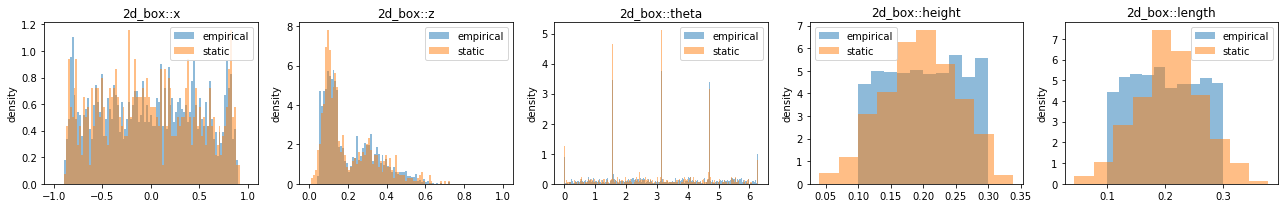

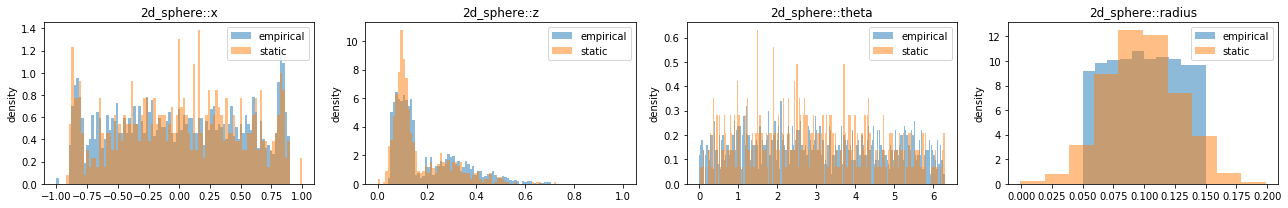

In [25]:
for object_name in params_by_object_class.keys():
    object_id = scenes_dataset.class_name_to_id[object_name]
    plt.figure().set_size_inches(18, 3)
    
    param_sets_base = [
        params_by_object_class[object_name],
        #params_by_object_class_nonpen[object_name],
        params_by_object_class_static[object_name]
    ]
    #params_sets_names = ["empirical", "nonpenetrating", "static"]
    params_sets_names = ["empirical", "static"]
    
    param_sets = []
    for params in param_sets_base:
        params_stacked = np.stack(params).copy()
        #params_stacked[2, :] = (params_stacked[2, :] + 2 * np.pi) % (2 * np.pi)
        param_sets.append(params_stacked)

    for k in range(param_sets[0].shape[1]):
        if k >= 3:
            param_name = scenes_dataset.params_names_by_class[object_id][k - 3]
        else:
            param_name = ["x", "z", "theta"][k]
        plt.subplot(1, param_sets[0].shape[1], k+1)
        plt.title(object_name + "::" + param_name)
        plt.ylabel("density")
        bins = None
        if k == 0:
            bins = np.linspace(-1., 1., 100)
        elif k == 1:
            bins = np.linspace(0., 1., 100)
        elif k == 2:
            bins = np.linspace(0, 2*np.pi, 200)
        for i, params in enumerate(param_sets):
            x_bins = plt.hist(params[:, k], label=params_sets_names[i], density=True, bins=bins, alpha=0.5)[1]
        x_range = np.linspace(x_bins[0], x_bins[-1], 100)
        plt.legend()
        
    plt.tight_layout()
    